In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import datetime as dt
import seaborn as sns

In [18]:
redfin = pd.read_csv('../1_data_raw/redfin_market_tracker_LI.csv')
redfin.head()

,Unnamed: 0,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,1146,2017-08-01,2017-08-31,30,county,5,1996,f,"Suffolk County, NY",NaN,...,-0.018610,0.165706,-0.031015,-0.045004,0.094444,0.002420,-0.014083,"Nassau County, NY",35004.0,2023-10-29 14:25:50
1,2300,2018-02-01,2018-02-28,30,county,5,1996,f,"Suffolk County, NY",NaN,...,-0.144231,0.138462,-0.039621,0.030618,0.000000,-0.133333,-0.090909,"Nassau County, NY",35004.0,2023-10-29 14:25:50
2,2885,2021-10-01,2021-10-31,30,county,5,1996,f,"Suffolk County, NY",NaN,...,0.034615,0.148148,0.010217,-0.151852,0.071429,-0.261905,-0.011905,"Nassau County, NY",35004.0,2023-10-29 14:25:50
3,4326,2023-08-01,2023-08-31,30,county,5,1996,f,"Suffolk County, NY",NaN,...,-0.135338,0.052632,0.002632,-0.072368,0.600000,0.327273,0.336842,"Nassau County, NY",35004.0,2023-10-29 14:25:50
4,4380,2013-04-01,2013-04-30,30,county,5,1996,f,"Suffolk County, NY",NaN,...,-0.005694,0.178679,0.036528,-0.010062,0.148196,-0.005650,0.016120,"Nassau County, NY",35004.0,2023-10-29 14:25:50


In [19]:
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1406 non-null   int64  
 1   period_begin                    1406 non-null   object 
 2   period_end                      1406 non-null   object 
 3   period_duration                 1406 non-null   int64  
 4   region_type                     1406 non-null   object 
 5   region_type_id                  1406 non-null   int64  
 6   table_id                        1406 non-null   int64  
 7   is_seasonally_adjusted          1406 non-null   object 
 8   region                          1406 non-null   object 
 9   city                            0 non-null      float64
 10  state                           1406 non-null   object 
 11  state_code                      1406 non-null   object 
 12  property_type                   14

By inspection, City is the only category with all null values, so we will drop it. We will also drop the last updated column because it isn't a real-estate metric.

In [20]:
redfin.drop(columns=['city', 'last_updated'], inplace=True)
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1406 non-null   int64  
 1   period_begin                    1406 non-null   object 
 2   period_end                      1406 non-null   object 
 3   period_duration                 1406 non-null   int64  
 4   region_type                     1406 non-null   object 
 5   region_type_id                  1406 non-null   int64  
 6   table_id                        1406 non-null   int64  
 7   is_seasonally_adjusted          1406 non-null   object 
 8   region                          1406 non-null   object 
 9   state                           1406 non-null   object 
 10  state_code                      1406 non-null   object 
 11  property_type                   1406 non-null   object 
 12  property_type_id                14

Now we subset the rows that need to be converted from string to numeric

In [21]:
to_encode = list(redfin.select_dtypes(include='object').columns)
to_encode

['period_begin',
 'period_end',
 'region_type',
 'is_seasonally_adjusted',
 'region',
 'state',
 'state_code',
 'property_type',
 'parent_metro_region']

We inspect the number of unique values in each of those rows to check the possibility of one-hot-encoding. Also noted is that none of these columns have null values. 

In [22]:
redfin[to_encode].nunique()

period_begin              141
period_end                141
region_type                 1
is_seasonally_adjusted      1
region                      2
state                       1
state_code                  1
property_type               5
parent_metro_region         1
dtype: int64

In [23]:
redfin.nunique()

Unnamed: 0                        1406
period_begin                       141
period_end                         141
period_duration                      1
region_type                          1
region_type_id                       1
table_id                             2
is_seasonally_adjusted               1
region                               2
state                                1
state_code                           1
property_type                        5
property_type_id                     5
median_sale_price                  643
median_sale_price_mom             1235
median_sale_price_yoy             1251
median_list_price                  158
median_list_price_mom              250
median_list_price_yoy              252
median_ppsf                       1358
median_ppsf_mom                   1381
median_ppsf_yoy                   1377
median_list_ppsf                   282
median_list_ppsf_mom               282
median_list_ppsf_yoy               282
homes_sold               

We will drop the columns with only one unique value because if the value is constant, it will not provide any information on the changes in data points.

In [24]:
ex_columns = ['region_type', 'is_seasonally_adjusted', 'state', 'state_code', 'parent_metro_region']
for column in ex_columns:
    to_encode.remove(column)
ex_columns.append("region_type_id")
ex_columns.append("period_duration")
ex_columns.append("parent_metro_region_metro_code")
redfin.drop(columns=ex_columns,inplace=True)
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   1406 non-null   int64  
 1   period_begin                 1406 non-null   object 
 2   period_end                   1406 non-null   object 
 3   table_id                     1406 non-null   int64  
 4   region                       1406 non-null   object 
 5   property_type                1406 non-null   object 
 6   property_type_id             1406 non-null   int64  
 7   median_sale_price            1406 non-null   float64
 8   median_sale_price_mom        1402 non-null   float64
 9   median_sale_price_yoy        1402 non-null   float64
 10  median_list_price            1403 non-null   float64
 11  median_list_price_mom        1396 non-null   float64
 12  median_list_price_yoy        1396 non-null   float64
 13  median_ppsf       

The columns period_begin and period_end have many unique values, which makes one-hot-encoding difficult. We will inspect the values in the column to see if any other transformation is possible.

In [25]:
date_columns = ['period_begin', 'period_end']
for column in date_columns:
    to_encode.remove(column)
redfin[date_columns].head()

,period_begin,period_end
0,2017-08-01,2017-08-31
1,2018-02-01,2018-02-28
2,2021-10-01,2021-10-31
3,2023-08-01,2023-08-31
4,2013-04-01,2013-04-30


These columns appear to be dates. Datetime objects aren't numeric so there are several ways we can approach this. One way is to convert the string object into a datetime object, which can then be turned into an ordinal value. 

In [26]:
redfin_dates = pd.to_datetime(redfin[date_columns].stack())
redfin_dates = redfin_dates.map(dt.datetime.toordinal).unstack()
redfin_dates

,period_begin,period_end
0,736542,736572
1,736726,736753
2,738064,738094
3,738733,738763
4,734959,734988
...,...,...
1401,734716,734746
1402,736116,736145
1403,735689,735718
1404,737303,737332


We can use the one-hot-encoder from sci-kit-learn to transform the rest of the string object columns into numeric columns

In [27]:
encoder = OneHotEncoder(handle_unknown='error', sparse=False)
redfin_enc = pd.DataFrame(encoder.fit_transform(redfin[to_encode]))
redfin_enc.columns = encoder.get_feature_names_out(to_encode)
redfin_enc.head()

c:\Users\home1\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,"region_Nassau County, NY","region_Suffolk County, NY",property_type_All Residential,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0


We will now replace the original columns with the encoded ones

In [28]:
redfin.drop(columns=to_encode,inplace=True)
redfin = redfin.join(redfin_enc)
redfin.head()

,Unnamed: 0,period_begin,period_end,table_id,property_type_id,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_list_price_mom,...,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,"region_Nassau County, NY","region_Suffolk County, NY",property_type_All Residential,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse
0,1146,2017-08-01,2017-08-31,1996,3,253750.0,-0.135434,-0.031858,369900.0,-0.000269,...,0.094444,0.002420,-0.014083,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2300,2018-02-01,2018-02-28,1996,4,395000.0,-0.097143,0.060545,399000.0,0.056179,...,0.000000,-0.133333,-0.090909,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2885,2021-10-01,2021-10-31,1996,13,475000.0,0.023707,0.011715,520500.0,0.006770,...,0.071429,-0.261905,-0.011905,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4326,2023-08-01,2023-08-31,1996,13,540000.0,-0.052632,0.200000,599000.0,0.000000,...,0.600000,0.327273,0.336842,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4380,2013-04-01,2013-04-30,1996,-1,300000.0,0.000000,0.052632,349997.0,0.037489,...,0.148196,-0.005650,0.016120,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [29]:
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 54 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               1406 non-null   int64  
 1   period_begin                             1406 non-null   object 
 2   period_end                               1406 non-null   object 
 3   table_id                                 1406 non-null   int64  
 4   property_type_id                         1406 non-null   int64  
 5   median_sale_price                        1406 non-null   float64
 6   median_sale_price_mom                    1402 non-null   float64
 7   median_sale_price_yoy                    1402 non-null   float64
 8   median_list_price                        1403 non-null   float64
 9   median_list_price_mom                    1396 non-null   float64
 10  median_list_price_yoy                    1396 no

Now we'll drop the columns that are repetitive or not useful for the topic.

In [30]:
drop_columns = ['median_sale_price_mom', 'median_sale_price_yoy', 'median_list_price_mom', 'median_list_price_yoy', 
                'median_list_ppsf_mom', 'median_list_ppsf_yoy', 'median_ppsf_mom', 'median_ppsf_yoy', 'homes_sold_mom',
                'homes_sold_yoy', 'pending_sales_mom', 'pending_sales_yoy', 'new_listings_mom', 'new_listings_yoy',
                'inventory_mom', 'inventory_yoy', 'months_of_supply_mom', 'months_of_supply_yoy', 'median_dom_mom',
                'median_dom_yoy', 'avg_sale_to_list_mom', 'avg_sale_to_list_yoy', 'sold_above_list_mom', 
                'sold_above_list_yoy', 'price_drops_mom', 'price_drops_yoy', 'off_market_in_two_weeks_mom',
                'off_market_in_two_weeks_yoy', "property_type_id", 'table_id', 'median_ppsf', 'median_list_ppsf']
redfin.drop(columns=drop_columns,inplace=True)
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               1406 non-null   int64  
 1   period_begin                             1406 non-null   object 
 2   period_end                               1406 non-null   object 
 3   median_sale_price                        1406 non-null   float64
 4   median_list_price                        1403 non-null   float64
 5   homes_sold                               1406 non-null   float64
 6   pending_sales                            1388 non-null   float64
 7   new_listings                             1403 non-null   float64
 8   inventory                                1406 non-null   float64
 9   months_of_supply                         1406 non-null   float64
 10  median_dom                               1406 no

We will check the columns that have null values

In [31]:
null_condition = np.sum(redfin.isnull()) != 0
redfin.columns[null_condition]

Index(['median_list_price', 'pending_sales', 'new_listings',
       'avg_sale_to_list', 'price_drops', 'off_market_in_two_weeks'],
      dtype='object')

In [32]:
to_impute = ['median_list_price', 'pending_sales',
            'new_listings', 'avg_sale_to_list', 'price_drops',
            'off_market_in_two_weeks']
for colname in to_impute:
    redfin[colname + "_na"] = redfin[colname].isnull()
mean_values = redfin[to_impute].mean()
redfin[to_impute] = redfin[to_impute].fillna(value=mean_values)
for colname in to_impute:
    print("{} missing values count :{}".format(colname, np.sum(redfin[colname].isnull(), axis = 0)))

median_list_price missing values count :0
pending_sales missing values count :0
new_listings missing values count :0
avg_sale_to_list missing values count :0
price_drops missing values count :0
off_market_in_two_weeks missing values count :0


In [33]:
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               1406 non-null   int64  
 1   period_begin                             1406 non-null   object 
 2   period_end                               1406 non-null   object 
 3   median_sale_price                        1406 non-null   float64
 4   median_list_price                        1406 non-null   float64
 5   homes_sold                               1406 non-null   float64
 6   pending_sales                            1406 non-null   float64
 7   new_listings                             1406 non-null   float64
 8   inventory                                1406 non-null   float64
 9   months_of_supply                         1406 non-null   float64
 10  median_dom                               1406 no

In [34]:
redfin.head()

,Unnamed: 0,period_begin,period_end,median_sale_price,median_list_price,homes_sold,pending_sales,new_listings,inventory,months_of_supply,...,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse,median_list_price_na,pending_sales_na,new_listings_na,avg_sale_to_list_na,price_drops_na,off_market_in_two_weeks_na
0,1146,2017-08-01,2017-08-31,253750.0,369900.0,256.0,180.0,225.0,694.0,2.7,...,1.0,0.0,0.0,0.0,False,False,False,False,False,False
1,2300,2018-02-01,2018-02-28,395000.0,399000.0,13.0,13.0,17.0,65.0,5.0,...,0.0,1.0,0.0,0.0,False,False,False,False,False,False
2,2885,2021-10-01,2021-10-31,475000.0,520500.0,13.0,14.0,12.0,27.0,2.1,...,0.0,0.0,0.0,1.0,False,False,False,False,False,False
3,4326,2023-08-01,2023-08-31,540000.0,599000.0,19.0,15.0,18.0,19.0,1.0,...,0.0,0.0,0.0,1.0,False,False,False,False,False,False
4,4380,2013-04-01,2013-04-30,300000.0,349997.0,823.0,776.0,2335.0,8311.0,10.1,...,0.0,0.0,0.0,0.0,False,False,False,False,False,False


In [35]:
redfin.corr().head()

C:\Users\home1\AppData\Local\Temp\ipykernel_1960\2619165200.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  redfin.corr().head()


,Unnamed: 0,median_sale_price,median_list_price,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,...,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse,median_list_price_na,pending_sales_na,new_listings_na,avg_sale_to_list_na,price_drops_na,off_market_in_two_weeks_na
Unnamed: 0,1.000000,0.121635,0.185636,-0.001314,-0.004627,-0.008005,-0.007348,0.017971,0.029058,-0.022103,...,0.005519,-0.039273,-0.004115,0.004102,4.186825e-02,3.584501e-02,4.186825e-02,-0.016097,0.010900,3.584501e-02
median_sale_price,0.121635,1.000000,0.681443,0.052133,0.108407,-0.014758,-0.151528,-0.206755,-0.203095,0.269030,...,-0.442639,0.165249,0.070044,0.178690,3.181878e-02,7.884091e-02,3.181878e-02,-0.057776,0.035559,7.884091e-02
median_list_price,0.185636,0.681443,1.000000,0.002069,0.100114,-0.041030,-0.253365,-0.335933,-0.342282,0.448829,...,0.000951,0.000951,0.000951,-0.003823,9.542125e-17,-4.671529e-03,9.542125e-17,-0.005505,0.009052,-4.671529e-03
homes_sold,-0.001314,0.052133,0.002069,1.000000,0.933456,0.891277,0.815846,-0.223777,-0.211737,0.234031,...,-0.295978,-0.415495,0.480676,-0.424290,-4.019458e-02,-9.885526e-02,-4.019458e-02,-0.023240,-0.076729,-9.885526e-02
pending_sales,-0.004627,0.108407,0.100114,0.933456,1.000000,0.921906,0.719388,-0.218350,-0.222349,0.282003,...,-0.292081,-0.396642,0.455447,-0.379942,-2.553731e-02,1.080726e-17,-2.553731e-02,-0.021799,-0.060149,1.080726e-17


In [36]:
corrs = redfin.corr()['median_sale_price']
corrs

C:\Users\home1\AppData\Local\Temp\ipykernel_1960\313755925.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = redfin.corr()['median_sale_price']


Unnamed: 0                                 0.121635
median_sale_price                          1.000000
median_list_price                          0.681443
homes_sold                                 0.052133
pending_sales                              0.108407
new_listings                              -0.014758
inventory                                 -0.151528
months_of_supply                          -0.206755
median_dom                                -0.203095
avg_sale_to_list                           0.269030
sold_above_list                            0.367400
price_drops                                0.046241
off_market_in_two_weeks                    0.209196
region_Nassau County, NY                   0.406548
region_Suffolk County, NY                 -0.406548
property_type_All Residential              0.029612
property_type_Condo/Co-op                 -0.442639
property_type_Multi-Family (2-4 Unit)      0.165249
property_type_Single Family Residential    0.070044
property_typ

In [37]:
corrs_sorted = corrs.sort_values(ascending=False)
corrs_sorted

median_sale_price                          1.000000
median_list_price                          0.681443
region_Nassau County, NY                   0.406548
sold_above_list                            0.367400
avg_sale_to_list                           0.269030
off_market_in_two_weeks                    0.209196
property_type_Townhouse                    0.178690
property_type_Multi-Family (2-4 Unit)      0.165249
Unnamed: 0                                 0.121635
pending_sales                              0.108407
pending_sales_na                           0.078841
off_market_in_two_weeks_na                 0.078841
property_type_Single Family Residential    0.070044
homes_sold                                 0.052133
price_drops                                0.046241
price_drops_na                             0.035559
median_list_price_na                       0.031819
new_listings_na                            0.031819
property_type_All Residential              0.029612
new_listings

In [41]:
top_two_corr = list(corrs_sorted.index[1:3])
top_two_corr

['median_list_price', 'region_Nassau County, NY']

In [42]:
top_two_corr.append('median_sale_price')
redfin_sub = redfin[top_two_corr]
redfin_sub.head()

,median_list_price,"region_Nassau County, NY",median_sale_price
0,369900.0,0.0,253750.0
1,399000.0,0.0,395000.0
2,520500.0,0.0,475000.0
3,599000.0,0.0,540000.0
4,349997.0,0.0,300000.0


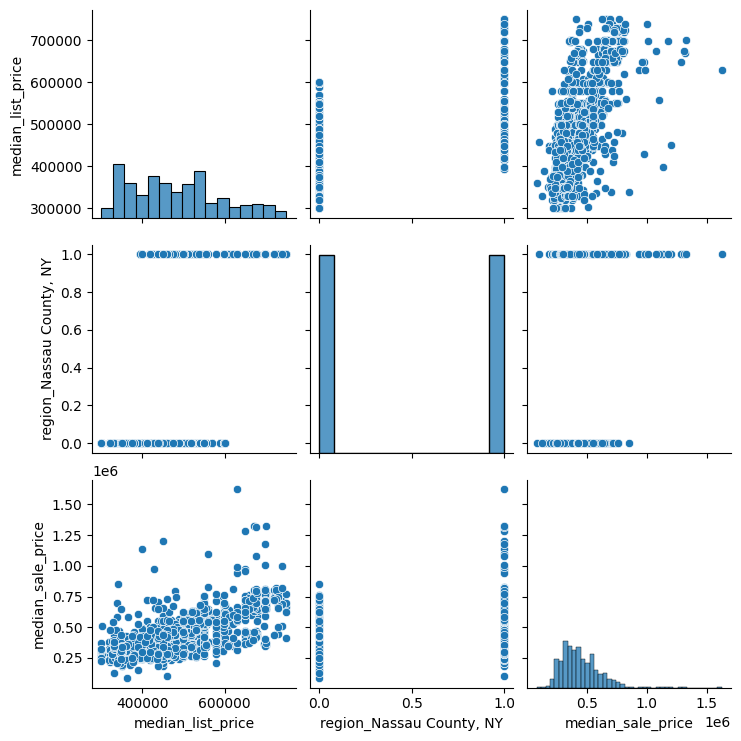

In [43]:
sns.pairplot(redfin_sub)

Notes:  
- possible dependent variable: median sale price  
- fewer null values (will probably impute or fill with 0)  
- also has info on how fast houses leave the market (**)  